In [ ]:
# !conda info -e

In [1]:
# 1つ前のディレクトリで作業する
%cd ../

/Users/daigomiyoshi/Desktop/keiba_modeling_pj/v3


In [2]:
import pymysql
import pandas as pd
import numpy as np
import category_encoders as ce
import joblib
import h2o
from h2o.automl import H2OAutoML


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')


from Config import params_config, db_config
from Utils.bulk_insert import BulkInsert

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [145]:
# from datetime import datetime

con = pymysql.connect(**db_config.db_params)

# parameters = params_config.parameters
parameters = {
    
    # parameters about columns names in dataframe
    'DATAFRAME_COL_NAMES': {
        'RACE_MASTER_INFO_COLS': [
            'race_id', 
            'race_place', 
            'race_kai', 
            'race_nichi', 
            'race_round', 
            'race_year', 
            'race_month', 
            'race_date', 
            'race_dow', 
            'race_course_baba', 
            'race_course_distance', 
            'race_course_mawari', 
            'race_weather', 
            'race_condition', 
            'starting_hour', 
            'starting_minutes'
        ],
        'RACE_TABLE_INFO_COLS': [
            'race_id',
            'horse_num',
            'bracket_num',
            'href_to_horse', 
            'horse_age', 
            'horse_sex',
            'weight_penalty',
            'weight_penalty_diff_from_avg',
            'href_to_jockey',
            'href_to_owner',
            'popularity_order',
            'win_odds'
        ],
        'RACE_RESULT_INFO_COLS': [
            'race_id',
            'bracket_num',
            'horse_num',
            'arrival_sec_diff_from_first',
            'arrival_order'
        ],
        'RACE_PAST_5_RACE_INFO_COLS': [
            'race_id',
            'horse_num',
            'count_of_latest_runs',
            'avg_arrival_order',
            'std_arrival_order',
            'latest_arrival_order'
        ],
        'DATAMART_FOR_MODEL_COLS': [
            'race_id',
            'horse_num',
            'race_horse_id',
            'bracket_num',
            'race_place', 
            'race_kai', 
            'race_nichi', 
            'race_round', 
            'race_year', 
            'race_month', 
            'race_date', 
            'race_dow', 
            'race_course_baba', 
            'race_course_distance', 
            'race_course_mawari', 
            'race_weather', 
            'race_condition', 
            'starting_hour', 
            'starting_minutes',
            'href_to_horse', 
            'horse_age', 
            'horse_sex',
            'weight_penalty',
            'weight_penalty_diff_from_avg',
            'href_to_jockey',
            'href_to_owner',
            'popularity_order',
            'win_odds',
            'count_of_latest_runs',
            'avg_arrival_order',
            'std_arrival_order',
            'latest_arrival_order',
            # 以下は結果に関する情報,
            'arrival_order', 
            'arrival_sec_diff_from_first', 
            'refund_yen'
        ],
        'RACE_REFUND_INFO_COLS': [
            'race_id', 
            'horse_num', 
            'refund_type', 
            'groupby_index', 
            'refund_yen'
        ]
    },
    'TRAIN_TEST_SPLIT': {
        'INDEX_COL': ['race_id', 'horse_num'],
        'FEATURE_COLS': ['popularity_order', 'win_odds', 'horse_sex'],
#         'EXCLUDE_COL': ['race_id', 'horse_num', 'y'],
        'TARGET_COL': 'y',
        'CRITERIA_TO_SPLIT_DATA': {'race_year': 2019, 'race_month': 12}
    },
    'DIR_NAME_OF_MODEL_PICKLE': 'Model/pickled_files/20200626/'
}

## Extract Data from DB

In [4]:
def _fetch_all_and_make_list_by(query, con):
    try:
        cursor = con.cursor()
        cursor.execute(query)
        fetch_result = cursor.fetchall()
        fetch_result_list = [item for item in fetch_result]
        cursor.close()
        return fetch_result_list
    except Exception as e:
        print(e)
        
def _read_query(query_file_path):
    with open(query_file_path, 'r', encoding='utf-8') as f:
        query = f.read()
    return query

def _get_data_frame_from_db(query_file_path, col_name_list, con):
    queries = _read_query(query_file_path)
    table_list = _fetch_all_and_make_list_by(queries, con)
    return pd.DataFrame(table_list, columns=col_name_list)

In [ ]:
race_master_df = _get_data_frame_from_db(
        query_file_path='SqlQuery/extract_race_master_info.sql', 
        col_name_list=parameters['DATAFRAME_COL_NAMES']['RACE_MASTER_INFO_COLS'],
        con=con
)

In [ ]:
race_table_df = _get_data_frame_from_db(
        query_file_path='SqlQuery/extract_race_table_info.sql', 
        col_name_list=parameters['DATAFRAME_COL_NAMES']['RACE_TABLE_INFO_COLS'],
        con=con
)

In [ ]:
race_past_5_race_df = _get_data_frame_from_db(
        query_file_path='SqlQuery/extract_race_past_5_result_info.sql', 
        col_name_list=parameters['DATAFRAME_COL_NAMES']['RACE_PAST_5_RACE_INFO_COLS'],
        con=con
)

In [ ]:
race_result_df = _get_data_frame_from_db(
        query_file_path='SqlQuery/extract_race_result_info.sql', 
        col_name_list=parameters['DATAFRAME_COL_NAMES']['RACE_RESULT_INFO_COLS'],
        con=con
)

In [ ]:
print(race_master_df.shape)
race_master_df.head()

In [ ]:
print(race_table_df.shape)
race_table_df.head()

In [ ]:
print(race_result_df.shape)
race_result_df.head()

In [ ]:
print(race_past_5_race_df.shape)
race_past_5_race_df.head()

## Exploratory data analysis
- レース毎に、予想順位=1の馬だけに100円単勝を投資する戦略：回収率 = 約-23%

### Q1. 予想順位が（結果より相対的に）低い/高い歪みはあるのか？

In [ ]:
query = '''
    WITH id_tab AS (
        SELECT race_id
        FROM race_master AS m
        -- WHERE (m.race_year=2019 AND m.race_month>=5) OR (m.race_year=2020 AND m.race_month>=1)
    )
    , race_card_tab AS (
        SELECT race_id
        , horse_num
        , MIN(win_odds) AS win_odds
        , MIN(popularity_order) AS popularity_order
        FROM race_table_info
        GROUP BY race_id, horse_num
    )
    , refund_tab AS (
        SELECT race_id
        , horse_num
        , MIN(refund_yen) AS refund_yen
        FROM race_refund_info
        WHERE refund_type = '単勝'
        GROUP BY race_id, horse_num
    )
    , agg_tab AS (
        SELECT a.race_id
        , CAST(b.horse_num AS SIGNED) AS horse_num
        , CAST(b.win_odds AS FLOAT) AS win_odds
        , CAST(b.popularity_order AS SIGNED) AS popularity_order
        , CAST(c.arrival_order AS SIGNED) AS arrival_order
        , CAST(d.refund_yen AS FLOAT) AS refund_yen
        FROM id_tab AS a
        LEFT OUTER JOIN race_card_tab AS b
        ON a.race_id = b.race_id
        LEFT OUTER JOIN race_result_info AS c
        ON a.race_id = c.race_id AND b.horse_num = c.horse_num
        LEFT OUTER JOIN refund_tab AS d
        ON a.race_id = d.race_id AND b.horse_num = d.horse_num
    )
    SELECT *
    FROM agg_tab
    WHERE arrival_order <> 0 AND popularity_order <> 0
'''

In [ ]:
df_for_eda_1 =  pd.DataFrame(
     _fetch_all_and_make_list_by(query, con), 
     columns=['race_id', 'horse_num', 'win_odds', 'popularity_order', 'arrival_order', 'refund_yen']
)

In [ ]:
print(df_for_eda_1.shape)
df_for_eda_1.head()

In [ ]:
pd.crosstab(index=df_for_eda_1['popularity_order'], columns=df_for_eda_1['arrival_order']).style.background_gradient(cmap='Blues')

In [ ]:
pd.crosstab(index=df_for_eda_1['popularity_order'], columns=df_for_eda_1['arrival_order']).apply(lambda x: x/x.sum(), axis=1).style.background_gradient(cmap='Blues')

- 2, 3, 4位予想の馬の着順が相対的に高い傾向？

### Q2. ある予想順位であるオッズ比以上の場合だけ投資するシミュレーションにより、一番回収額・回収率が高い閾値は？

- 該当予想順位を1-18位までそれぞれ固定し、
- 予想順位の馬のオッズ比が、決めた閾値を上回っていれば投資する（下回っていれば非投資）
- 予想順位と閾値を動かしていき、利益額・利益率をシミュレーションする

=> モデリング時に考えなくて良い予想順位やオッズ比を決めたい

In [ ]:
query = """
WITH 
race_table_info_mod AS (
    SELECT race_id
    , horse_num
    , CAST(win_odds AS FLOAT) AS win_odds
    , CAST(popularity_order AS SIGNED) AS popularity_order
    FROM race_table_info
)
, refund_tab AS (
    SELECT race_id
    , horse_num
    , MIN(refund_yen) AS refund_yen
    FROM race_refund_info
    WHERE refund_type = '単勝'
    GROUP BY race_id, horse_num
)
SELECT a.*
, c.arrival_order
, CASE WHEN b.refund_yen IS NOT NULL THEN b.refund_yen ELSE 0 END AS refund_yen
FROM race_table_info_mod AS a
LEFT OUTER JOIN refund_tab AS b
ON a.race_id = b.race_id AND a.horse_num = b.horse_num
LEFT OUTER JOIN race_result_info AS c
ON a.race_id = c.race_id AND a.horse_num = c.horse_num
WHERE a.win_odds <> 0 AND a.popularity_order <> 0
AND c.arrival_order IS NOT NULL
"""

df_for_eda_2 =  pd.DataFrame(
     _fetch_all_and_make_list_by(query, con), 
     columns=['race_id', 'horse_num', 'win_odds', 'popularity_order', 'arrival_order', 'refund_yen']
)

In [ ]:
print(df_for_eda_2.shape)
df_for_eda_2.head()

#### オッズ比の傾向を可視化する

In [ ]:
print(min(df_for_eda_2['win_odds']))
print(max(df_for_eda_2['win_odds']))

In [ ]:
fig = plt.figure(figsize=(15, 8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_for_eda_2['win_odds'], bins=50, alpha=0.6)
plt.show()

In [ ]:
# オッズ比が20以下
fig = plt.figure(figsize=(15, 8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_for_eda_2[df_for_eda_2['win_odds'] <= 20]['win_odds'], bins=50, alpha=0.6)
ax.set_xlim([1.0, 20.0])
plt.show()

In [ ]:
profit_amount_list = []
popularity_order_range = list(range(1, 19))
win_odds_range = [1.0, 1.5, 3.0, 5.0, 7.5, 10.0, 12.5, 15.0, 20, 30, 40, 50, 75, 100]

for race_id in df_for_eda_2['race_id'].unique()[::-1]:
    print(race_id)
    each_race_df = df_for_eda_2[df_for_eda_2['race_id']==race_id]
    for pop_order in popularity_order_range:
        target_horse = each_race_df[each_race_df['popularity_order'] == pop_order]
        for win_odds in win_odds_range:
            try:
                if float(target_horse['win_odds']) >= win_odds:
                    investment_amount = 100
                    profit_amount = int(target_horse['refund_yen']) - investment_amount
                else:
                    investment_amount = 0
                    profit_amount = 0
                profit_amount_list.append([race_id, pop_order, win_odds, investment_amount, profit_amount])
            except TypeError:
                continue

In [ ]:
profit_amount_df = pd.DataFrame(profit_amount_list, 
                                columns=['race_id', 'popularity_order', 'win_odds', 'investment_amount', 'profit_amount'])

profit_amount_groupby = profit_amount_df.groupby(['popularity_order', 'win_odds'], as_index=False).sum()
profit_amount_groupby['profit_rate'] = profit_amount_groupby['profit_amount'] / (profit_amount_groupby['investment_amount']+0.001)
# profit_amount_groupby.head()

In [ ]:
investment_amount_pivot = profit_amount_groupby.pivot(index='popularity_order', columns='win_odds', values='investment_amount')
investment_amount_pivot.style.background_gradient(cmap='Blues')

In [ ]:
profit_amount_pivot = profit_amount_groupby.pivot(index='popularity_order', columns='win_odds', values='profit_amount')
profit_amount_pivot.style.background_gradient(cmap='Blues')

In [ ]:
profit_rate_pivot = profit_amount_groupby.pivot(index='popularity_order', columns='win_odds', values='profit_rate')
profit_rate_pivot.style.background_gradient(cmap='Blues')

- 予想順位が8位以下の場合は回収率が悪くなる
    - 10位以下のデータは（学習の際に）差っ引いても良いかもしれない
- オッズ比に関しては、閾値による差はそこまでない
    - あまり高い閾値で切っても投資量が減って意味がないので

#### データ数の可視化

In [ ]:
ariival_order_cnt = df_for_eda_2.groupby('arrival_order', as_index=False).count()[['arrival_order', 'race_id']]
ariival_order_cnt = ariival_order_cnt.query("arrival_order not in ['', '中止']").astype({'arrival_order': int}).sort_values('arrival_order')
ariival_order_cnt = ariival_order_cnt.astype({'arrival_order': str})
ariival_order_cnt

In [ ]:
fig = plt.figure(figsize=(15, 8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.bar(ariival_order_cnt['arrival_order'], ariival_order_cnt['race_id'], alpha=0.8)
plt.show()

## Preprocess / Modeling

In [214]:
# functions for Preprocess 
def _define_target_variable(row, time_diff, model_type, obj_type):
    if model_type == 'tansho' and obj_type == 'odds_or_zero':
        if row['arrival_order'] == 1 or row['arrival_sec_diff_from_first'] < time_diff:
            return row['win_odds']
        else:
            return 0
    elif model_type == 'tansho' and obj_type == 'one_or_zero':
        if row['arrival_order'] == 1 or row['arrival_sec_diff_from_first'] < time_diff:
            return 1
        else:
            return 0
    elif model_type == 'fukusho' and obj_type == 'one_or_zero':
        if row['arrival_order'] in [1, 2, 3] or row['arrival_sec_diff_from_first'] < time_diff:
            return 1
        else:
            return 0

        
def preprocess_target_variable(df, time_diff, model_type, obj_type):
    df['y'] = df.apply(_define_target_variable, axis=1, time_diff = time_diff, model_type=model_type, obj_type=obj_type)
    return df

def subset_datamart(df, thr_pop_order):
    df = df[df['popularity_order'] < thr_pop_order]
    return df


# functions for Modeling
def make_train_test_data(parameters, dataset, how_to_select):
    index_cols = parameters['TRAIN_TEST_SPLIT']['INDEX_COL']
    if how_to_select == 'include':
        feature_cols = parameters['TRAIN_TEST_SPLIT']['FEATURE_COLS']
    elif how_to_select == 'exclude':
        feature_cols = [col for col in list(dataset.columns) if col not in parameters['TRAIN_TEST_SPLIT']['EXCLUDE_COL']]
    target_col = parameters['TRAIN_TEST_SPLIT']['TARGET_COL']
    criteria_to_split_dict = parameters['TRAIN_TEST_SPLIT']['CRITERIA_TO_SPLIT_DATA']
    
    train_df = pd.DataFrame()
    train_df = pd.concat([train_df, dataset[dataset['race_year'] < criteria_to_split_dict['race_year']]])
    train_df = pd.concat([train_df, dataset[
        (dataset['race_year'] == criteria_to_split_dict['race_year']) & 
        (dataset['race_month'] <= criteria_to_split_dict['race_month'])
    ]])
    Idx_train = train_df[index_cols]
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    
    test_df = pd.DataFrame()
    test_df = pd.concat([test_df, dataset[dataset['race_year'] > criteria_to_split_dict['race_year']]])
    test_df = pd.concat([test_df, dataset[
        (dataset['race_year'] == criteria_to_split_dict['race_year']) & 
        (dataset['race_month'] > criteria_to_split_dict['race_month'])
    ]])
    Idx_test = test_df[index_cols]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    return Idx_train, X_train, y_train, Idx_test, X_test, y_test


def fit_model_into_data_by(parameters, model_type, X_train, X_test, y_train, y_test):
    if model_type == 'h2o_reg' or model_type == 'h2o_clf':
        x=list(X_train.columns)
        y=parameters['TRAIN_TEST_SPLIT']['TARGET_COL']
        h2o.init(ip="127.0.0.1", max_mem_size_GB=4)
        hdf = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
        
        if model_type == 'h2o_clf':
            hdf[y] = hdf[y].asfactor()
        
        aml = H2OAutoML(max_models=5, seed=1, max_runtime_secs=432000)
        aml.train(
            x=list(X_train.columns),
            y=parameters['TRAIN_TEST_SPLIT']['TARGET_COL'],
            training_frame=hdf
        )
        # lb = aml.leaderboard
        # print(lb.head(rows=lb.nrows))
        model_path = h2o.save_model(
            model=aml.leader,
            path=parameters['DIR_NAME_OF_MODEL_PICKLE']+'fitted_'+model_type+'_model',
            force=True
        )
        saved_model = h2o.load_model(model_path)
        y_test_pred = saved_model.predict(h2o.H2OFrame(X_test)).as_data_frame()
        
    elif model_type == 'rf':
        rf_reg = RandomForestRegressor(
            n_estimators=1000,
            max_depth=10,
            max_features='sqrt',
            n_jobs=-1,
            verbose=1,
            random_state=1
        )
        rf_reg.fit(X_train, y_train)
        joblib.dump(rf_reg, parameters['DIR_NAME_OF_MODEL_PICKLE']+'fitted_'+model_type+'_model.pkl')
        y_test_pred = rf_reg.predict(X_test)

    return y_test_pred

### 単勝予測モデル
- 0/1、もしくは、1位回収率（1位もしくは1位とタイム僅差だったらオッズ比、それ以外は0）を目的変数？
    - 後者の場合は、べき分布となっているので、目的変数は対数変換？
- レース毎に予測値が最大の馬が閾値を超えたら購入する？

In [162]:
datamart = _get_data_frame_from_db(
        query_file_path='SqlQuery/extract_data_mart_for_modeling.sql', 
        col_name_list=parameters['DATAFRAME_COL_NAMES']['DATAMART_FOR_MODEL_COLS'],
        con=con
)

In [215]:
print(datamart.shape)
datamart.head()

(603556, 36)


,race_id,horse_num,race_horse_id,bracket_num,race_place,race_kai,race_nichi,race_round,race_year,race_month,race_date,race_dow,race_course_baba,race_course_distance,race_course_mawari,race_weather,race_condition,starting_hour,starting_minutes,href_to_horse,horse_age,horse_sex,weight_penalty,weight_penalty_diff_from_avg,href_to_jockey,href_to_owner,popularity_order,win_odds,count_of_latest_runs,avg_arrival_order,std_arrival_order,latest_arrival_order,arrival_order,arrival_sec_diff_from_first,refund_yen,y
0,200801010101,1,200801010101_01,1,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006104966/,2,牡,54.0,0.43,https://db.netkeiba.com/jockey/00945/,https://db.netkeiba.com/trainer/01059/,1,3.1,1.0,3.0,0.0,3.0,3.0,0.008,0,0
1,200801010101,2,200801010101_02,2,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006110090/,2,牝,54.0,0.43,https://db.netkeiba.com/jockey/01084/,https://db.netkeiba.com/trainer/00419/,6,21.9,1.0,9.0,0.0,9.0,5.0,0.010,0,0
2,200801010101,3,200801010101_03,3,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006104842/,2,牡,54.0,0.43,https://db.netkeiba.com/jockey/01032/,https://db.netkeiba.com/trainer/01016/,3,4.6,2.0,2.5,0.5,3.0,6.0,1.667,0,0
3,200801010101,4,200801010101_04,3,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006104817/,2,牡,54.0,0.43,https://db.netkeiba.com/jockey/01026/,https://db.netkeiba.com/trainer/00401/,9,46.9,1.0,5.0,0.0,5.0,12.0,1.678,0,0
4,200801010101,5,200801010101_05,4,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006102676/,2,牡,53.0,-0.57,https://db.netkeiba.com/jockey/01102/,https://db.netkeiba.com/trainer/00412/,11,111.7,1.0,9.0,0.0,9.0,9.0,1.668,0,0


#### パターン1: 目的変数は0/1・予想順位とオッズ比のみを特徴量とした場合
- 目的変数: 1位であれば1、それ以外は0
- 学習データの対象範囲：
    - 1. 競馬場毎にモデルを分ける?
    - 2. 10位未満の予想順位のみに絞る?

##### 前処理

In [216]:
# datamart = subset_datamart(df=datamart, thr_pop_order=10)
datamart = preprocess_target_variable(df=datamart, time_diff = 0.000, model_type='fukusho', obj_type='one_or_zero')
datamart.head()

,race_id,horse_num,race_horse_id,bracket_num,race_place,race_kai,race_nichi,race_round,race_year,race_month,race_date,race_dow,race_course_baba,race_course_distance,race_course_mawari,race_weather,race_condition,starting_hour,starting_minutes,href_to_horse,horse_age,horse_sex,weight_penalty,weight_penalty_diff_from_avg,href_to_jockey,href_to_owner,popularity_order,win_odds,count_of_latest_runs,avg_arrival_order,std_arrival_order,latest_arrival_order,arrival_order,arrival_sec_diff_from_first,refund_yen,y
0,200801010101,1,200801010101_01,1,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006104966/,2,牡,54.0,0.43,https://db.netkeiba.com/jockey/00945/,https://db.netkeiba.com/trainer/01059/,1,3.1,1.0,3.0,0.0,3.0,3.0,0.008,0,1
1,200801010101,2,200801010101_02,2,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006110090/,2,牝,54.0,0.43,https://db.netkeiba.com/jockey/01084/,https://db.netkeiba.com/trainer/00419/,6,21.9,1.0,9.0,0.0,9.0,5.0,0.010,0,0
2,200801010101,3,200801010101_03,3,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006104842/,2,牡,54.0,0.43,https://db.netkeiba.com/jockey/01032/,https://db.netkeiba.com/trainer/01016/,3,4.6,2.0,2.5,0.5,3.0,6.0,1.667,0,0
3,200801010101,4,200801010101_04,3,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006104817/,2,牡,54.0,0.43,https://db.netkeiba.com/jockey/01026/,https://db.netkeiba.com/trainer/00401/,9,46.9,1.0,5.0,0.0,5.0,12.0,1.678,0,0
4,200801010101,5,200801010101_05,4,1,1,1,1,2008,8,16,土,芝,1500,右,曇,良,10,40,https://db.netkeiba.com/horse/2006102676/,2,牡,53.0,-0.57,https://db.netkeiba.com/jockey/01102/,https://db.netkeiba.com/trainer/00412/,11,111.7,1.0,9.0,0.0,9.0,9.0,1.668,0,0


In [217]:
print(min(datamart['y']))
print(max(datamart['y']))

0
1


##### 目的変数に関する可視化

In [218]:
# fig = plt.figure(figsize=(15, 8), dpi=100)
# ax = fig.add_subplot(1, 1, 1)
# ax.hist(datamart['y'], alpha=0.6)
# plt.show()

In [219]:
print(datamart.shape[0])
print(datamart['y'].value_counts())
print(datamart['y'].value_counts() / datamart.shape[0])

603556
0    476827
1    126729
Name: y, dtype: int64
0    0.790029
1    0.209971
Name: y, dtype: float64


##### 学習

In [220]:
Idx_train, X_train, y_train, Idx_test, X_test, y_test = make_train_test_data(
    parameters=parameters, dataset=datamart, how_to_select='include'
)
print(X_train.shape)
print(X_test.shape)

X_train.head()

(580062, 3)
(23494, 3)


,popularity_order,win_odds,horse_sex
0,1,3.1,牡
1,6,21.9,牝
2,3,4.6,牡
3,9,46.9,牡
4,11,111.7,牡


In [ ]:
y_test_pred = fit_model_into_data_by(
    parameters=parameters,
    model_type='h2o_clf',
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

In [118]:
### 学習済モデルを使用する場合 ###

# h2o.init(ip="127.0.0.1", max_mem_size_GB=4)
# model_path = parameters['DIR_NAME_OF_MODEL_PICKLE'] + 'fitted_h2o_clf_model/XGBoost_3_AutoML_20200626_151444'
# saved_model = h2o.load_model(model_path)

# y_test_pred = saved_model.predict(h2o.H2OFrame(X_test)).as_data_frame()

Checking whether there is an H2O instance running at http://127.0.0.1:54321 . connected.


H2O cluster uptime:,22 hours 4 mins
H2O cluster timezone:,Asia/Tokyo
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,7 months and 19 days !!!
H2O cluster name:,H2O_from_python_daigomiyoshi_elpulk
H2O cluster total nodes:,1
H2O cluster free memory:,1.340 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


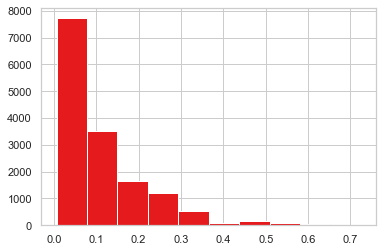

In [119]:
y_test_pred['p1'].hist()

##### シミュレーション

- 1位確率に基づいて、以下のパターンでTestデータにおけるシミュレーションを行い、回収額・回収率を検証する
    - レース毎に、TopNの馬の(予測値, オッズ比)が(閾値X, 閾値Y)以上であれば、各馬に単勝として100円投資
    - レース毎に、TopNの馬の(予測値, オッズ比)が(閾値X, 閾値Y)以上であれば、各馬に複勝として100円投資
        - (正確には、複勝の場合は目的変数の定義を複勝に相当するように変えておく必要があるが、シミュレーションは念の為行う)

In [ ]:
def make_test_dataset(Idx_test, y_test_pred, y_test, model_type):
    Idx_test = Idx_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if model_type == 'clf':
        try:
            y_pred_proba = pd.DataFrame({'y_pred_proba': y_test_pred['p1']})
        except KeyError:
            y_pred_proba = pd.DataFrame({'y_pred_proba': y_test_pred['predict']})
        y_pred_proba = y_pred_proba.reset_index(drop=True)
    elif model_type == 'reg':
        pass
    
    return pd.concat([pd.concat([Idx_test, y_pred_proba], axis=1), y_test], axis=1)

In [41]:
race_refund_df = _get_data_frame_from_db(
        query_file_path='SqlQuery/extract_race_refund_info.sql', 
        col_name_list=parameters['DATAFRAME_COL_NAMES']['RACE_REFUND_INFO_COLS'],
        con=con
)
print(race_refund_df.shape)
race_refund_df.head()

(924917, 5)


,race_id,horse_num,refund_type,groupby_index,refund_yen
0,200901010101,4,単勝,1,710
1,200901010101,4,複勝,1,150
2,200901010101,12,複勝,2,120
3,200901010101,3,複勝,3,180
4,200901010101,4,枠連,1,590


In [131]:
test_dataset = make_test_dataset(Idx_test, y_test_pred, y_test, model_type='clf')
print(test_dataset.shape)
print('レース数: ', len(test_dataset.race_id.unique()))
test_dataset.head()

(15008, 4)
レース数:  1680


,race_id,horse_num,y_pred_proba,y
0,202002010101,3,0.038048,0
1,202002010101,4,0.135737,0
2,202002010101,6,0.089800,0
3,202002010101,7,0.046267,1
4,202002010101,8,0.150987,0


In [209]:
def calc_profit_in_tansho_or_fukusho(top_n_horse_df, rece_refund_df):
    race_id = top_n_horse_df['race_id'].iloc[0]
    rece_refund_df = rece_refund_df.query('race_id == @race_id')
    invest_result_df = pd.merge(top_n_horse_df, rece_refund_df, on=['race_id', 'horse_num'], how='left')[[
        'race_id', 'horse_num', 'is_invested', 'refund_yen'
    ]].query('is_invested == 1')
    invest_yen = np.sum(invest_result_df['is_invested'] * 100)
    refund_yen = np.nansum(invest_result_df['refund_yen'])
    profit_yen = refund_yen - invest_yen if invest_yen>0 else 0
    return invest_yen, refund_yen, profit_yen


def calc_profit_in_fixed_params(df, rece_refund_df, sim_type, top_n, proba_thr):
    top_n_horse_df = df.sort_values(by='y_pred_proba', ascending=False).iloc[:top_n, :]
    top_n_horse_df['is_invested'] = top_n_horse_df['y_pred_proba'].apply(lambda x: 1 if x >= proba_thr else 0)
    
    if sim_type == '単勝' or sim_type == '複勝':
        invest_yen, refund_yen, profit_yen = calc_profit_in_tansho_or_fukusho(top_n_horse_df, rece_refund_df)
    elif sim_type == 'ワイド':
        pass
    
    return pd.DataFrame({
        'top_n': top_n,
        'proba_thr': proba_thr,
        'invest_yen': invest_yen,
        'refund_yen': refund_yen,
        'profit_yen': profit_yen
    }, index=[''])


def simulate_profit_in_test_data(test_dataset, race_refund_df, sim_type):
    rece_refund_df_subset = race_refund_df.query('refund_type == @sim_type')
    profit_amount_df = pd.DataFrame()
    
    proba_thr_range = [0.3, 0.35, 0.4]
    top_n_range = [1]
    for top_n in top_n_range:
        for proba_thr in proba_thr_range:
            each_race_df = pd.DataFrame(
                test_dataset.groupby(['race_id'], as_index=True).apply(
                    calc_profit_in_fixed_params,
                    rece_refund_df=rece_refund_df_subset, 
                    sim_type=sim_type, 
                    top_n=top_n,
                    proba_thr=proba_thr
                )
            ).reset_index(level='race_id')
            profit_amount_df = pd.concat([profit_amount_df, each_race_df])
    return profit_amount_df

In [210]:
profit_amount_df = simulate_profit_in_test_data(test_dataset, race_refund_df, sim_type='複勝')

profit_amount_groupby = profit_amount_df.groupby(['top_n', 'proba_thr'], as_index=False).sum()
profit_amount_groupby['profit_rate'] = profit_amount_groupby['profit_yen'] / (profit_amount_groupby['invest_yen']+0.001)

In [211]:
invest_amount_pivot = profit_amount_groupby.pivot(index='proba_thr', columns='top_n', values='invest_yen')
invest_amount_pivot.style.background_gradient(cmap='Blues')

top_n,1
proba_thr,
0.3,82200
0.35,44300
0.4,37200


In [212]:
profit_amount_pivot = profit_amount_groupby.pivot(index='proba_thr', columns='top_n', values='profit_yen')
profit_amount_pivot.style.background_gradient(cmap='Blues')

top_n,1
proba_thr,
0.3,-10250
0.35,-4600
0.4,-3480


In [213]:
profit_rate_pivot = profit_amount_groupby.pivot(index='proba_thr', columns='top_n', values='profit_rate')
profit_rate_pivot.style.background_gradient(cmap='Blues')

top_n,1
proba_thr,
0.3,-0.124696
0.35,-0.103837
0.4,-0.0935484


In [197]:
invest_amount_pivot = profit_amount_groupby.pivot(index='proba_thr', columns='top_n', values='invest_yen')
invest_amount_pivot.style.background_gradient(cmap='Blues')

top_n,1
proba_thr,
0.3,82200


In [198]:
profit_amount_pivot = profit_amount_groupby.pivot(index='proba_thr', columns='top_n', values='profit_yen')
profit_amount_pivot.style.background_gradient(cmap='Blues')

top_n,1
proba_thr,
0.3,-18190


In [199]:
profit_rate_pivot = profit_amount_groupby.pivot(index='proba_thr', columns='top_n', values='profit_rate')
profit_rate_pivot.style.background_gradient(cmap='Blues')

top_n,1
proba_thr,
0.3,-0.22129
